In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd
from importlib import reload
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D

from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sb

from matplotlib import rcParams

import titanic_util as tu
from pca import PCA
from voting_ensemble import VotingEnsemble
from logistic_regressor import LogisticRegressor

pd.options.display.max_rows = 20

%autoreload 2

In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 6,5

In [4]:
titanic_data = tu.load(opt='train')

attaching_keys=['Sex','Age','Fare','Pclass','Embarked','SibSp','Parch',np.array(['Parch','SibSp'])]

new_data, data_targets = tu.mung(titanic_data, attaching_keys, base_truth='Survived')

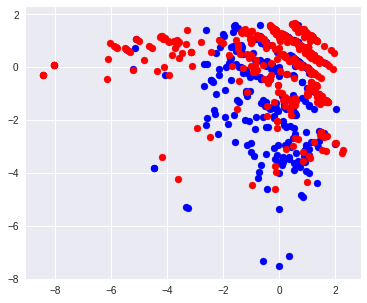

In [5]:
pca_vis = PCA(task_type='reduce_dim', pc_count=2)
reduced_data = pca_vis.fit(new_data)

reduced_data = DataFrame(reduced_data); reduced_data.index = new_data.index

who_lives = reduced_data.loc[data_targets==1]
who_dies = reduced_data.loc[data_targets==0]

plt.scatter(who_lives.iloc[:,0], who_lives.iloc[:,1], color='b')
plt.scatter(who_dies.iloc[:,0], who_dies.iloc[:,1], color='r')
plt.show()

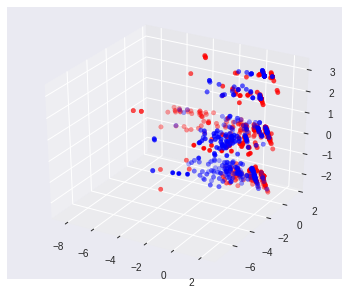

In [6]:
#TODO plot in 3-D as well

pca_vis = PCA(task_type='reduce_dim', pc_count=3)
reduced_data = pca_vis.fit(new_data)

reduced_data = DataFrame(reduced_data); reduced_data.index = new_data.index

who_lives = reduced_data.loc[data_targets==1]
who_dies = reduced_data.loc[data_targets==0]

xlive = np.array(who_lives.iloc[:,0])
ylive = np.array(who_lives.iloc[:,1])
zlive = np.array(who_lives.iloc[:,2])

xdie = np.array(who_dies.iloc[:,0])
ydie = np.array(who_dies.iloc[:,1])
zdie = np.array(who_dies.iloc[:,2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xlive, ylive, zlive, color='b')
ax.scatter(xdie, ydie, zdie, color='r')
plt.show()

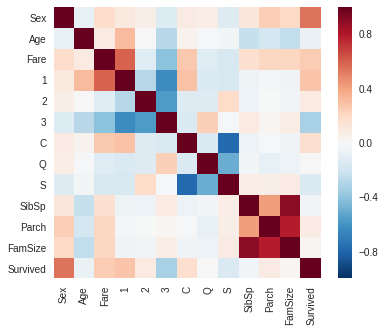

In [7]:
corr = new_data.join(titanic_data['Survived']).corr()

display(sb.heatmap(corr))

In [8]:
metric = 'f1_score'

log_reg = LogisticRegressor(max_it=5000, lambd=0.3, alpha=0.01)

X_train, y_train, X_val, y_val = tu.split_train_cv(new_data, data_targets)

theta = log_reg.fit(X_train, y_train, print_stats=True, return_differences=True)

train_predictions = log_reg.predict(X_train, theta)
cv_predictions = log_reg.predict(X_val, theta)

train_err = tu.get_error(train_predictions, y_train, metric='f1_score')
cv_err = tu.get_error(cv_predictions, y_val, metric='f1_score')

print('Training {} was {}'.format(metric, 1 - train_err))
print('Cross-validation {} was {}'.format(metric, 1 - cv_err))
print('Optimal weights are: \n{}'.format(theta))

converged after 321 iterations.
Training f1_score was 0.6958333333333333
Cross-validation f1_score was 0.7894736842105263
Optimal weights are: 
Bias      -0.310977
Sex        0.507711
Age       -0.111444
Fare       0.185356
1          0.223673
2          0.078272
3         -0.256420
C          0.081791
Q          0.019539
S         -0.088761
SibSp     -0.054460
Parch      0.044518
FamSize   -0.014981
dtype: float64


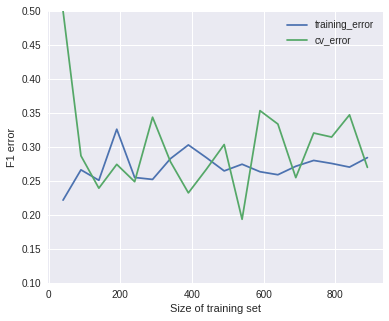

In [9]:
weights, train_error_curve, cv_error_curve = tu.learning_curves(new_data, data_targets, log_reg, min_val=40, step=50, print_stats=False)

plt.ylim(0.10,0.50)

plt.plot(np.fromiter(train_error_curve.keys(), dtype=int), np.fromiter(train_error_curve.values(), dtype=float), label='training_error')
plt.plot(np.fromiter(cv_error_curve.keys(), dtype=int), np.fromiter(cv_error_curve.values(), dtype=float), label='cv_error')

plt.legend(loc='best')

plt.xlabel('Size of training set')
plt.ylabel('F1 error')

plt.show()

In [10]:
testing_data = tu.load('test')

testing_data = tu.mung(testing_data, attaching_keys)

pred = log_reg.predict(testing_data, theta)

display(pred)

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      1
9      0
      ..
408    0
409    0
410    0
411    1
412    0
413    0
414    1
415    0
416    0
417    0
Length: 418, dtype: int64